In [1]:
import pickle
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import time
import numpy as np
#from fairlearn.datasets import fetch_acs_income
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?


from scipy import stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
import joblib

In [ ]:
raw_data = pd.read_csv("ACSPUMS1.csv")
#raw_data = pd.read_csv("ACSPUMS5Y2023_2025-06-08T180031.csv")

In [3]:
df = raw_data.drop(columns=['Unnamed: 13', 'PWGTP'], errors='ignore')

# preprocess NAICS
df = df[df['NAICSP'] !='N']
df = df[df['NAICSP'] !='999920']

In [4]:
raw_data = df.copy()

# Categorize AGEP into bins
age_bins = [15, 25, 45, 60, float('inf')]
age_labels = ['15_25', '25_45', '45_60', '60_plus']
raw_data['AGEP'] = pd.cut(raw_data['AGEP'], bins=age_bins, labels=age_labels, right=False)

# Binarize MAR
raw_data['MAR'] = raw_data['MAR'].apply(lambda x: 1 if x == 1 else 0)

# Filter by RAC1P values
valid_rac1p_values = [1, 2, 6, 8, 9]
raw_data = raw_data[raw_data['RAC1P'].isin(valid_rac1p_values)]

In [ ]:
raw_data['strata'] = raw_data[['DIS', 'NATIVITY','RAC1P','SEX', 'MAR', 'AGEP']].astype(str).agg('_'.join, axis=1)
sample,_ = train_test_split(raw_data, 
                             train_size=500_000, 
                             stratify=raw_data['strata'], 
                             random_state=42)

sample.drop('strata', axis=1, inplace=True)

In [6]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP','DIS', 'NATIVITY','NAICSP','SCHL', 'MAR', 'ENG', 'SEX',  'RAC1P']

In [7]:
insurance_data = sample.copy() # create new df for insurance predictions
income_data = sample.copy()

insurance_data.rename(columns={"HICOV": "target"}, inplace=True)
income_data.drop('HICOV', axis = 1, inplace=True)
income_data.rename(columns={"PINCP": "target"}, inplace=True)

In [8]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    y = df_copy['binary_target']
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')

    return X, y


preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor1.fit(X_train)

X_train_income = preprocessor1.transform(X_train)
X_val_income   = preprocessor1.transform(X_val)
X_test_income  = preprocessor1.transform(X_test)
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val



In [ ]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor2.fit(X_train)

X_train_health = preprocessor2.transform(X_train)
X_val_health   = preprocessor2.transform(X_val)
X_test_health  = preprocessor2.transform(X_test)

y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val




In [ ]:
income_feature_names = preprocessor1.named_transformers_['cat'].get_feature_names_out(categorical_cols)
health_feature_names = preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(income_feature_names) + numeric_cols
all_feature_names_health = list(health_feature_names) + numeric_cols_health

In [ ]:
# Get the SHAP-values

#file_path = 'deepshap_values_health.pkl'

#with open(file_path, 'rb') as file:
#    shap_values = pickle.load(file)
# ----------------------------------------------
shap_values = np.load(r"C:\Users\odiee\OneDrive\Documents\GitHub\HCML\SHAP_values_income_health\TreeSHAP_Income\treeshap_values_income.npy")
#shap_values = (np.load("deepshap_values_income.npy"))
# ----------------------------------------------
#shap_values = joblib.load("deepshap_explainer_income.joblib", mmap_mode=None)

In [ ]:
# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = shap_values[mask_A.values]
shap_female = shap_values[mask_B.values]
feature_names = ['COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 'SEX_1.0', 'SEX_2.0', 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_3.0', 'RAC1P_4.0', 'RAC1P_5.0', 'RAC1P_6.0', 'RAC1P_7.0', 'RAC1P_8.0', 'RAC1P_9.0', 'AGEP', 'WKHP']

shapiro_list = []
shapiro_listW = []
levenes = []
z_list = []
t_test = []
print(len(feature_names))

normality_warnings = 0
varience_warnings = 0

for i, feature in enumerate(all_feature_names_income):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    # randomly sample 5000 instances of both groups
    try:
        group1 = np.random.choice(group1, size=5000, replace=False)
        group2 = np.random.choice(group2, size=5000, replace=False)
    except:
        pass # array is already less than 5000

    # normalise:
    '''
    group1 = preprocessing.normalize([group1], norm='l2')
    group2 = preprocessing.normalize([group2], norm='l2')
    '''
    # Shapiro-Wilk test
    shapiro_gr1 = shapiro(group1).pvalue
    shapiro_gr2 = shapiro(group2).pvalue
    shapiroW_gr1 = shapiro(group1).statistic
    shapiroW_gr2 = shapiro(group2).statistic
    shapiro_list.append([shapiro_gr1, shapiro_gr2])
    shapiro_listW.append([shapiroW_gr1, shapiroW_gr2])

    # Levenes test ---> depends on assumption of normality!
    w_stats, p_value = levene(group1, group2, center='mean')
    levenes.append([w_stats, p_value])

    # outlier test ---> depends on assumption of normality!
    z1 = np.abs(stats.zscore(group1))
    z2 = np.abs(stats.zscore(group2))
    z_list.append([z1, z2])

    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    t_test.append([stat,pval])


print("Shapiro values: ", shapiro_list)
print("Shapiro statistic: ", shapiro_listW)
print("Levens values: ", levenes)

68
hello
Shapiro values:  [[np.float64(3.647000080104339e-83), np.float64(2.4035263234148836e-83)], [np.float64(8.438223097782625e-56), np.float64(7.57133285698835e-55)], [np.float64(1.2450476673171705e-60), np.float64(1.6800392722718408e-59)], [np.float64(7.116677658430212e-55), np.float64(3.2446724955365765e-53)], [np.float64(2.004622054638557e-83), np.float64(3.1147092177281115e-84)], [np.float64(8.118881144985193e-81), np.float64(5.672182112943503e-82)], [np.float64(3.044366951654717e-72), np.float64(2.531450797521347e-76)], [np.float64(6.526452425826035e-81), np.float64(3.76021966392686e-80)], [np.float64(8.10868106260149e-93), np.float64(3.37015107633268e-94)], [np.float64(3.3483459900927575e-94), np.float64(1.5234768738429667e-94)], [np.float64(2.1270607982197027e-95), np.float64(1.793308688200484e-85)], [np.float64(9.776502408794012e-96), np.float64(1.2596586160167503e-95)], [np.float64(1.2028850796803736e-95), np.float64(9.58669900665352e-96)], [np.float64(2.313412274585409e-9

In [14]:
print("z-scores that deviate: ", z_list)
print("t-test  values: ",t_test)

z-scores that deviate:  [[array([0.39499924, 0.37755617, 2.758678  , ..., 0.40786913, 0.3734374 ,
       0.38075548], dtype=float32), array([0.34790885, 0.3834168 , 0.40252942, ..., 0.37430495, 0.38098902,
       0.44754237], dtype=float32)], [array([0.40205926, 0.5847557 , 1.0120945 , ..., 0.8825995 , 1.2979871 ,
       1.077758  ], dtype=float32), array([0.81737536, 1.4032608 , 0.8986552 , ..., 1.3798494 , 1.0471574 ,
       1.0072517 ], dtype=float32)], [array([1.2347989 , 0.30801114, 1.3802679 , ..., 0.7577562 , 1.4388556 ,
       0.4797733 ], dtype=float32), array([1.261428  , 3.3546634 , 0.8583402 , ..., 0.92215675, 0.52555025,
       0.76227033], dtype=float32)], [array([1.3198056 , 1.5817168 , 0.3479597 , ..., 1.7158128 , 0.41666812,
       0.17576906], dtype=float32), array([0.27497193, 0.2649548 , 1.7961155 , ..., 0.17489377, 0.10423102,
       1.6998255 ], dtype=float32)], [array([0.3879331 , 0.39058438, 0.34581214, ..., 0.3403079 , 0.20709093,
       3.35498   ], dtype=floa

Statistical to-do:
1) L2 - normalize all SHAP vectors to be used
2) Apply Shapiro-Wilk test on a sample of N = 5000 to check for normality
3) Independent t-test / non-parametric test regardless of small p-values
4) effect size (threshold of D <= 0.2)
 

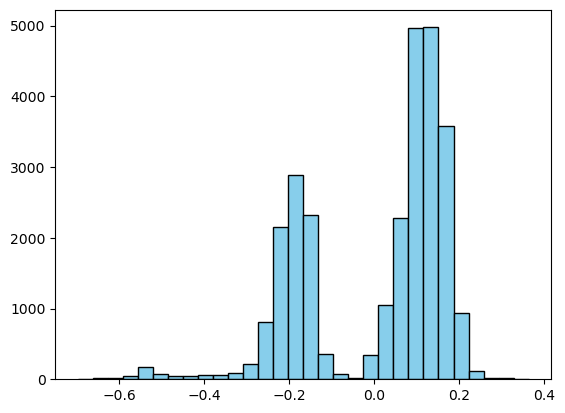

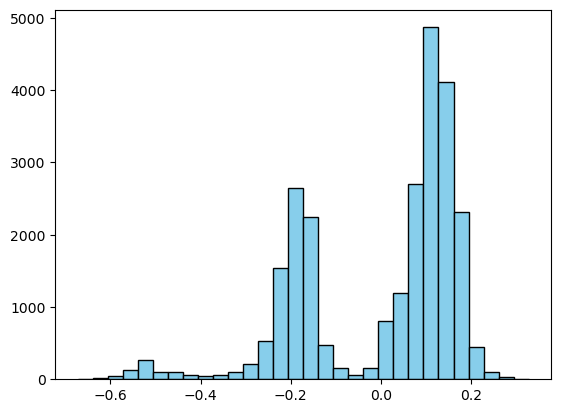

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i+1]
    group2 = shap_female[:, i+1]

    plt.hist(group1, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    plt.hist(group2, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    break